# Personal Note Embedding

For this exercise, the objective is to visualize the word embedding of my 1000+ personal notes that span over 1 year. My notetaking tool, Roam Research, allows me to download all of the notes on my graph as individual markdown files. Each note represents a document and my entire graph represents a corpus of documents.

Preprocessing the text data into a high quality format is of high importance for meaningful insights of the word embedding and to ensure the input into the algorithm is sensible. Since the data is coming from my local Roam Research graph, the initial data extraction will be done locally with the converted html to csv files  being stored on my Google Cloud Drive. 

Conversion of the markdown to html to csv files along with the BeautifulSoup html extraction can be found on the following public GitHub repository:

  - [Roam Research Graph Embedding](https://github.com/GStechschulte/Side_Projects/tree/main/Roam_Research_Embedding)


## A Quick Background on the Notes

The 1000+ documents consist of mainly my interests in machine learning. Therefore, the majority of the notes are related to data science, statistics, probability, and computer science—STEM related fields. However, there are also documents in regard to notes on books read, podcasts listened to and random ideas / thoughts I have had. Furthermore, in some notes there are embedded pictures and formulas and equations written in LaTeX. It's safe to say that the notes consist of a wide range of content and will be interesting to preprocess and visualize.

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib
import matplotlib.pyplot as plt
from google.colab import files, drive
from glob import glob
import os
import regex

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [121]:
# Reading all .csv files and converting them to dataframes
path = '/content/drive/MyDrive/CLT/roam/'
all_files = glob(os.path.join(path, '*.csv'))

file_list=[]

for file in all_files:
    df = pd.read_csv(file, usecols=['content'], index_col=None, header=0)
    file_list.append(df)

# Concat since all dataframes have the same column
big_df = pd.concat(file_list, axis=0, ignore_index=True)
big_df.dropna(how='any', inplace=True)

In [122]:
big_df

,content
0,. #[[Cornell ML]]. Regression just ...
1,. List of presidents who where deep ...
2,. 2d transformations carry over to 3...
3,. . I would really like to go in dep...
4,. — via Aave – Open Source DeFi Pro...
...,...
964,. #[[Statistical Learning in R]]. F...
965,. . Kedro. .
966,". . Ensemble method in which each ""t..."
967,. Generalized Linear Models book. ....


In [123]:
len(big_df)

733

# Text Preprocessing

As previously mentioned, my notes have a diverse set of characters such as LaTeX symbols, hypens, em dashes, pound signs, etc. All of these needs to be removed before I can start modeling. As well, for each document, there is often the same words such as "DONE", "TODO", "Metadata", and "Tags" which also need to be removed.

## Removal of Certain Characters

In [124]:
def remove_char_re(text):
  text = re.sub(r"[\([{})\]]", "", text)
  text = re.sub(r"[^a-zA-Z\s]", "", text)
  text = re.sub(r"\#", "", text)
  text = re.sub(r"\$", "", text)
  text = re.sub(r"\-", "", text)
  text = re.sub(r"\:", "", text)

  return text

In [125]:
def remove_words(words):
  assert words != list

  for word in words:
    big_df['content'] = big_df['content'].str.replace('{}'.format(word), '')
  
  return big_df

In [126]:
big_df['content'] = big_df['content'].apply(remove_char_re)
big_df = remove_words(['DONE', 'done', 'TODO',
                       'Metadata', 'Tags', 'via'])

## Redundant Whitespaces and Periods

In [127]:
def remove_redundant_whitespaces(text):
    text = re.sub(r'\s+'," ", text)
    text = re.sub(r'\.+'," ", text)
    return text.strip()

In [128]:
big_df['content'] = big_df['content'].apply(remove_redundant_whitespaces)

In [132]:
big_df

,content
0,Cornell ML Regression just says we a...
1,List of presidents who where deep in...
2,d transformations carry over to d an...
3,I would really like to go in depth a...
4,Aave Open Source DeFi Protocol
...,...
964,Statistical Learning in R Functions ...
965,Kedro
966,Ensemble method in which each tree b...
967,Generalized Linear Models book Zero ...


# Tokenization

For the tokenization, I noticed some tokens consisted of one character. I would also like to test the word embedding with and without stop words. Two functions will be implemented to test the results of the Word2Vec embedding with and without stop words. 

In [135]:
import spacy
from spacy.lang.en import English
nltk.download('stopwords')
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [136]:
def tokenizer_filter_stop_words(doc):
  tokens = wpt.tokenize(doc)
  tokens = [t.lower() for t in tokens]
  # Filter stopwords out of document
  filtered_tokens = [token for token in tokens if token not in stop_words]

  return filtered_tokens

In [137]:
big_df['wo_stop'] = big_df['content'].apply(tokenizer_filter_stop_words)

In [138]:
# Disable all the annotators except the tokenizer so its fast
nlp = English(disable=['tagger', 'parser', 'ner'])

def tokenizer_with_stop_words(text):
  return [t.text.lower() for t in nlp(text)]  

In [139]:
big_df['tokens_w_stop'] = big_df['content'].apply(tokenizer_with_stop_words)

In [140]:
big_df

,content,wo_stop,tokens_w_stop
0,Cornell ML Regression just says we a...,"[cornell, ml, regression, says, regi...","[cornell, ml, regression, just, says..."
1,List of presidents who where deep in...,"[list, presidents, deep, math, abrah...","[list, of, presidents, who, where, d..."
2,d transformations carry over to d an...,"[transformations, carry, mathbbrd, p...","[d, transformations, carry, over, to..."
3,I would really like to go in depth a...,"[would, really, like, go, depth, joi...","[i, would, really, like, to, go, in,..."
4,Aave Open Source DeFi Protocol,"[aave, open, source, defi, protocol]","[aave, open, source, defi, protocol]"
...,...,...,...
964,Statistical Learning in R Functions ...,"[statistical, learning, r, functions...","[statistical, learning, in, r, funct..."
965,Kedro,[kedro],[kedro]
966,Ensemble method in which each tree b...,"[ensemble, method, tree, boosts, att...","[ensemble, method, in, which, each, ..."
967,Generalized Linear Models book Zero ...,"[generalized, linear, models, book, ...","[generalized, linear, models, book, ..."


# Word2Vec

In [141]:
from gensim.models import Word2Vec

## Without Stop Words

In [152]:
# Set values for various parameters
feature_size = 100  # Word vector dimensionality
window_context = 7  # Context window size
min_word_count = 5  # Minimum word count

w2vmodel = Word2Vec(
    sentences=big_df['wo_stop'], 
    size=feature_size, 
    window=window_context, 
    min_count=min_word_count, 
    sg = 0)

In [151]:
# Similar Words
similar_words = {
    search_term:
    [item[0] for item in w2vmodel.wv.most_similar([search_term], topn=5)]
    for search_term in ['statistics', 'probability', 'data', 'computer']
}
similar_words

{'computer': ['ability', 'vaccine', 'step', 'new', 'world'],
 'data': ['set', 'problem', 'based', 'means', 'particular'],
 'probability': ['distribution', 'given', 'variables', 'values', 'random'],
 'statistics': ['research', 'modeling', 'methods', 'vs', 'science']}

In [ ]:
w2vmodel.wv.index2word[250:350]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


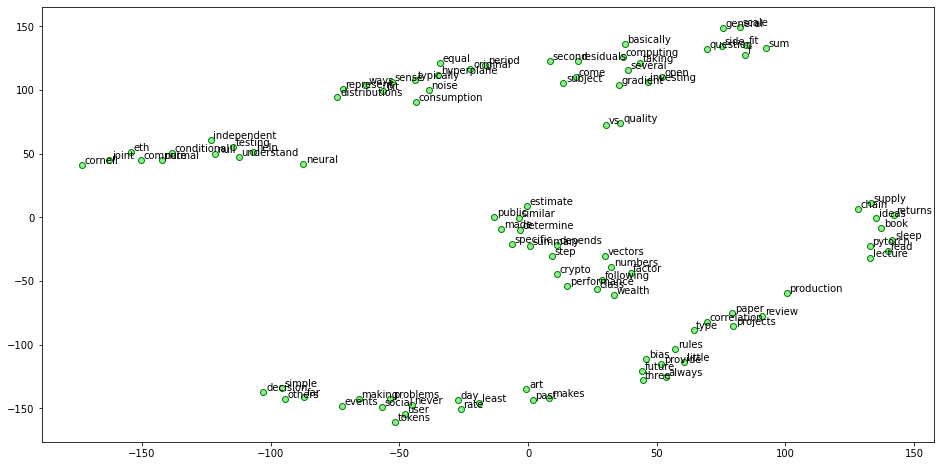

In [154]:
from sklearn.manifold import TSNE

words = w2vmodel.wv.index2word[250:350]               ## get the word forms of voculary sample
wvs = w2vmodel.wv[words]                              ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(16, 8))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')
plt.show()

## With Stop Words

In [157]:
# Set values for various parameters
feature_size = 100  # Word vector dimensionality
window_context = 7  # Context window size
min_word_count = 5  # Minimum word count

w2vmodel = Word2Vec(
    sentences=big_df['tokens_w_stop'], 
    size=feature_size, 
    window=window_context, 
    min_count=min_word_count, 
    sg = 0)

In [159]:
# Similar Words
similar_words = {
    search_term:
    [item[0] for item in w2vmodel.wv.most_similar([search_term], topn=5)]
    for search_term in ['statistics', 'probability', 'data', 'computer']
}
similar_words

{'computer': ['why', 'take', 'go', 'long', 'exactly'],
 'data': ['by', 'linear', 'regression', 'models', 'for'],
 'probability': ['distribution', 'x', 'value', 'variable', 'the'],
 'statistics': ['for', 'group', 'svm', 'rd', 'sql']}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


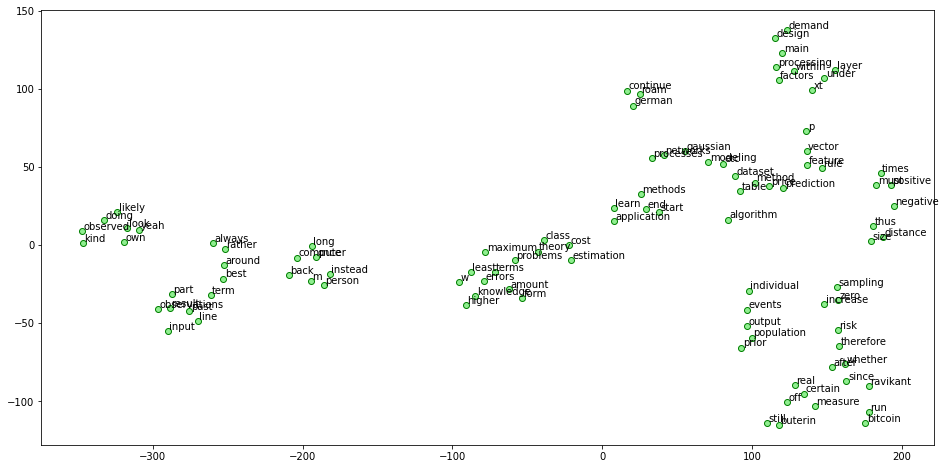

In [158]:
words = w2vmodel.wv.index2word[250:350]               ## get the word forms of voculary sample
wvs = w2vmodel.wv[words]                              ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(16, 8))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')
plt.show()

# Summary